## Problem solution using PyGAD package

In [5]:
import numpy as np
import pygad
from fitness import fitness_multi_objective, fitness_max_energy_production
from plotting import *
from utils import is_layout_valid
import logging
import itertools

In [6]:
# set figsize and dpi for all figures
saved_figure_figsize, saved_figure_dpi = plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"]
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 90

In [7]:
# PROBLEM CONSTANTS
n_turbines = 14
area_size = 300
min_spacing = 50
wind_speed = 9.8
wind_direction = 270.0
fitness_weights = {
        'energy_production': 0.5,
        'boundary_fitness': 0.2,
        'spacing_fitness': 0.2,
        'wake_fitness': 0.1,
        'is_valid': 1,
    }

In [8]:
def fitness_func(ga_instance, solution, solution_idx):
    solution = solution.reshape((n_turbines, 2)).astype(int)
    return fitness_multi_objective(solution, fitness_weights, area_size, min_spacing, wind_speed, wind_direction)

In [9]:
num_genes = 2 * n_turbines

num_generations = 100
num_parents_mating = 2
sol_per_pop = 100


init_range_low = 0
init_range_high = area_size
parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_percent_genes = 10
stop_criteria = "saturate_5"


initial_population = np.random.uniform(
    low=init_range_low, high=init_range_high, size=(sol_per_pop, num_genes)
)


ga_instance = pygad.GA(
    initial_population=initial_population,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    parent_selection_type=parent_selection_type,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    stop_criteria=stop_criteria
)

/opt/anaconda3/lib/python3.11/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


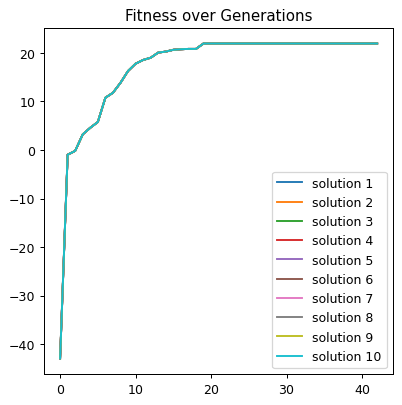

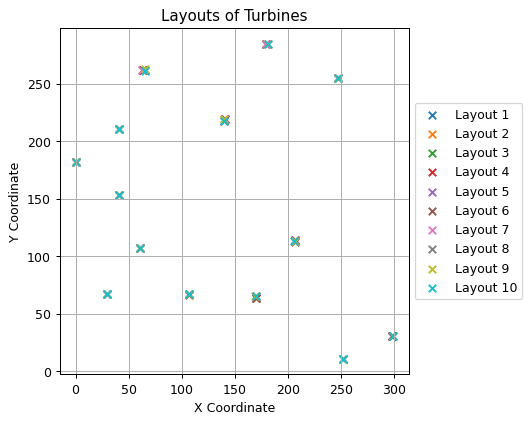

solution 1 valid: True , score: 21.950000000000006
solution 2 valid: True , score: 21.950000000000006
solution 3 valid: True , score: 21.950000000000006
solution 4 valid: True , score: 21.950000000000006
solution 5 valid: True , score: 21.950000000000006
solution 6 valid: True , score: 21.950000000000006
solution 7 valid: True , score: 21.950000000000006
solution 8 valid: True , score: 21.950000000000006
solution 9 valid: True , score: 21.950000000000006
solution 10 valid: True , score: 21.950000000000006


In [10]:
best_layouts = []
best_fitness_values = []
fitness_values = []

num_simulations = 10
for i in range(num_simulations):
    ga_instance.run()

    best_solution, best_solution_fitness, _ = ga_instance.best_solution()
    best_solution = best_solution.reshape((n_turbines, 2)).astype(int)
    
    best_layouts.append(best_solution)
    best_fitness_values.append(best_solution_fitness)
    fitness_values.append(ga_instance.best_solutions_fitness)

plot_solutions_data_stats(fitness_values, "Fitness over Generations")
plot_multiple_layouts(best_layouts)

valid_solutions = []
for i, (layout, score) in enumerate(zip(best_layouts, best_fitness_values)):
    valid = is_layout_valid(layout, area_size, min_spacing)
    print(f"solution {i+1} valid:", valid, ", score:", score)
    if valid:
        valid_solutions.append([layout, score])

Best solution fitness:  21.950000000000006


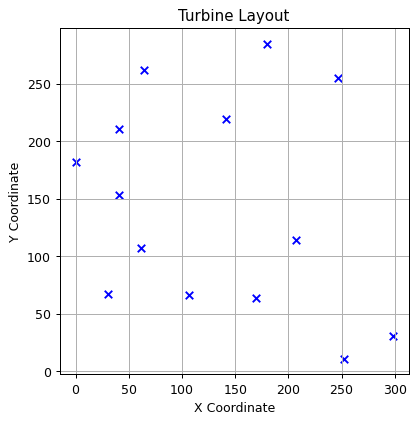

In [11]:
if valid_solutions:
    single_best_layout, single_best_fitness = max(valid_solutions, key=lambda x: x[1])
    print("Best solution fitness: ", single_best_fitness)
    plot_turbine_layout(single_best_layout)
else:
    print("No valid solutions")

### Using grid search to find the best combinations of hyperparameters

In [12]:
from sklearn.base import BaseEstimator

In [23]:
# parent_selection_types = ["sss", "rws", "sus", "rank", "random", "tournament"]
# crossover_types = ["single_point", "two_points", "uniform", "scattered"]
# mutation_types = ["random", "swap", "inversion", "scramble", "adaptive"]

param_grid = {
    'num_generations': [50, 100],
    'num_parents_mating': [2, 4],
    'sol_per_pop': [100],
    'parent_selection_type': ["sss", "rws", "sus", "rank", "random", "tournament"],
    'crossover_type': ["single_point", "two_points", "uniform", "scattered"],
    'mutation_type': ["random", "swap", "inversion", "scramble"],
    'mutation_probability': [0.1, 0.25],
    'stop_criteria': ["saturate_5"]
}

In [24]:
class GAEstimator(BaseEstimator):
    def __init__(self, num_generations=100, num_parents_mating=2, sol_per_pop=100, 
                 parent_selection_type="sss", crossover_type="single_point",
                 mutation_type="random", mutation_probability=10, stop_criteria=None):
        self.best_solution_fitness = None
        self.best_solution = None
        self.num_generations = num_generations
        self.num_parents_mating = num_parents_mating
        self.sol_per_pop = sol_per_pop
        self.parent_selection_type = parent_selection_type
        self.crossover_type = crossover_type
        self.mutation_type = mutation_type
        self.mutation_probability = mutation_probability
        self.stop_criteria = stop_criteria

    def fit(self, X):
        initial_population = X

        self.ga_instance = pygad.GA(
            initial_population=initial_population,
            num_generations=self.num_generations,
            num_parents_mating=self.num_parents_mating,
            fitness_func=fitness_func,
            sol_per_pop=self.sol_per_pop,
            num_genes=len(initial_population),
            init_range_low=init_range_low,
            init_range_high=init_range_high,
            parent_selection_type=self.parent_selection_type,
            crossover_type=self.crossover_type,
            mutation_type=self.mutation_type,
            mutation_probability=self.mutation_probability,
            stop_criteria=self.stop_criteria,
            random_seed=42
        )

        self.ga_instance.run()

        self.best_solution, self.best_solution_fitness, _ = self.ga_instance.best_solution()
        self.best_solution = self.best_solution.reshape((n_turbines, 2)).astype(int)
        return self

    def score(self):
        return self.best_solution_fitness
    
    def get_solution(self):
        return self.best_solution
    

In [26]:
param_combinations = list(itertools.product(
    param_grid['num_generations'],
    param_grid['num_parents_mating'],
    param_grid['sol_per_pop'],
    param_grid['parent_selection_type'],
    param_grid['crossover_type'],
    param_grid['mutation_type'],
    param_grid['mutation_probability'],
    param_grid['stop_criteria']
))


best_score = -np.inf
best_params = None
best_estimator = None

# initial population
np.random.seed(42)
X = np.random.uniform(
    low=init_range_low, high=init_range_high, size=(param_grid['sol_per_pop'][0], 2 * n_turbines)
)

for combination in param_combinations:
    num_generations, num_parents_mating, sol_per_pop, parent_selection_type, crossover_type, mutation_type, mutation_probability, stop_criteria = combination
    ga_estimator = GAEstimator(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        sol_per_pop=sol_per_pop,
        parent_selection_type=parent_selection_type,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_probability=mutation_probability,
        stop_criteria=stop_criteria
    )

    ga_estimator.fit(X)
    score = ga_estimator.score()

    logging.basicConfig(level=logging.INFO)
    logging.info(f"Parameters: {combination}, Score: {score}")

    if score > best_score:
        best_score = score
        best_params = combination
        best_estimator = ga_estimator

# Output the best parameters and score
print("Best parameters found: ", best_params)
print("Best score: ", best_score)

INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'random', 0.1, 'saturate_5'), Score: 20.350000000000005
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'random', 0.25, 'saturate_5'), Score: 20.450000000000006
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'swap', 0.1, 'saturate_5'), Score: 16.726803838006816
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'swap', 0.25, 'saturate_5'), Score: 16.726803838006816
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'inversion', 0.1, 'saturate_5'), Score: 21.050000000000004
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'inversion', 0.25, 'saturate_5'), Score: 21.050000000000004
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'scramble', 0.1, 'saturate_5'), Score: 18.109056020284502
INFO:root:Parameters: (50, 2, 100, 'sss', 'single_point', 'scramble', 0.25, 'saturate_5'), Score: 18.109056020284502
INFO:root:Parameters: (50, 2, 100, 'sss', 'two_points', 'random', 0.1, 'satura

Best parameters found:  (50, 4, 100, 'sss', 'two_points', 'scramble', 0.1, 'saturate_5')
Best score:  22.750000000000007


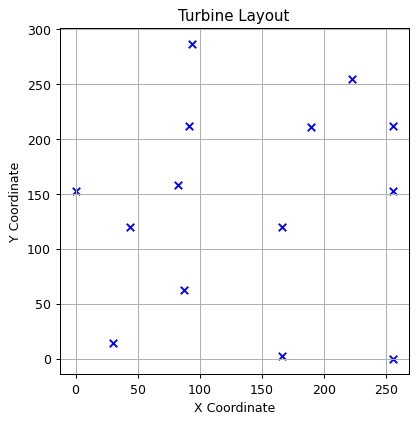

Best solution fitness:  22.750000000000007
Is best solution valid:  True
Fitness max energy production:  23.450000000000006
solution/max_energy_production: 97.01492537313433 %


In [27]:
best_estimator = GAEstimator(*best_params)
best_estimator.fit(X)

best_layout, best_fitness = best_estimator.get_solution(), best_estimator.score()
plot_turbine_layout(best_layout)
max_energy_production = fitness_max_energy_production(best_layout, fitness_weights, wind_speed)
print("Best solution fitness: ", best_fitness)
print("Is best solution valid: ", is_layout_valid(best_layout, area_size, min_spacing))
print("Fitness max energy production: ", max_energy_production)
print(f"solution/max_energy_production: {best_fitness/max_energy_production * 100} %")